In [ ]:
!pip install ultralytics
!pip install playsound
!pip install cvzone
!pip install --upgrade pip setuptools wheel
!pip install gtts

<IPython.core.display.Javascript object>

Saved image to photo.jpg

0: 480x640 1 person, 104.3ms
I see a person
Speed: 5.3ms preprocess, 104.3ms inference, 737.7ms postprocess per image at shape (1, 3, 480, 640)
Saved detection results to output_with_detections.jpg


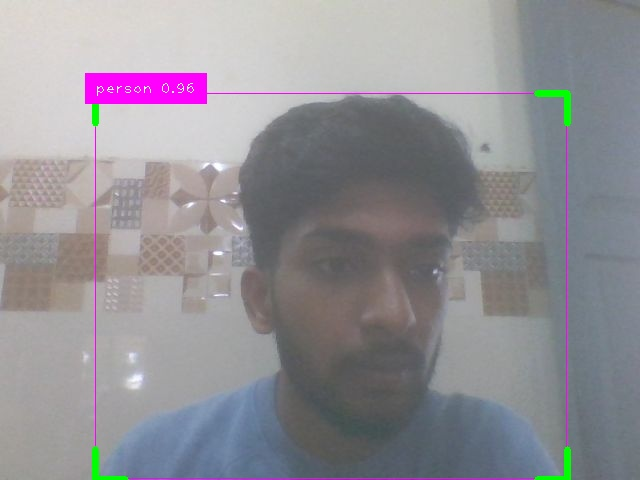

Audio saved as prediction_1731658086.mp3


In [ ]:
import cv2
import cvzone
import math
import time
import os
import threading
import queue
from gtts import gTTS
from ultralytics import YOLO
from IPython.display import Audio, display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

# Function to capture image from the browser webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Load YOLOv8 model
model = YOLO("../Yolo-Weights/yolov8l.pt")

# Class names
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush", "pen", "notebook", "laptop charger", "smartwatch",
              "headphones", "microphone", "whiteboard", "projector", "speakers", "desk lamp", "water bottle",
              "coffee mug", "stapler", "printer"]

# Queue for audio announcements
audio_queue = queue.Queue()
# Track last announced objects to avoid repetition
last_announced = set()
# Time interval to reset last announced objects (in seconds)
reset_interval = 10
start_time = time.time()

# Function to play audio
def play_audio():
    while True:
        text = audio_queue.get()
        if text is None:
            break
        filename = f"prediction_{int(time.time())}.mp3"
        try:
            # Generate speech from text
            speech_object = gTTS(text=text, lang='en', slow=False)
            speech_object.save(filename)
            print(f"Audio saved as {filename}")

            # Display an audio player in Colab
            display(Audio(filename))
        except Exception as e:
            print(f"Error generating audio: {e}")
        finally:
            audio_queue.task_done()

# Start audio thread
audio_thread = threading.Thread(target=play_audio, daemon=True)
audio_thread.start()

# Capture an image from webcam
try:
    filename = take_photo()
    print(f"Saved image to {filename}")

    # Read the captured image using OpenCV
    img = cv2.imread(filename)

    # YOLO inference
    results = model(img, stream=True)

    announcements = 0
    max_announcements_per_frame = 3  # Limit the number of objects to announce per frame
    current_time = time.time()

    if current_time - start_time > reset_interval:
        last_announced.clear()
        start_time = current_time

    for r in results:
        boxes = r.boxes
        for box in boxes:
            # Bounding Box
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # Draw rectangle around detected objects
            w, h = x2 - x1, y2 - y1
            cvzone.cornerRect(img, (x1, y1, w, h))

            # Confidence level
            conf = math.ceil((box.conf[0] * 100)) / 100
            # Class Name
            cls = int(box.cls[0])

            # Display class name and confidence on the image
            cvzone.putTextRect(img, f'{classNames[cls]} {conf}', (max(0, x1), max(35, y1)), scale=1, thickness=1)

            # Audio Feedback for detected objects
            name = classNames[cls]
            if name not in last_announced and announcements < max_announcements_per_frame:
                announcement = f"I see a {name}"
                print(announcement)
                audio_queue.put(announcement)
                last_announced.add(name)
                announcements += 1

    # Save the image with detections
    output_filename = 'output_with_detections.jpg'
    cv2.imwrite(output_filename, img)
    print(f"Saved detection results to {output_filename}")

    # Display the image with detections
    display(Image(output_filename))

except Exception as e:
    print(f"Error: {e}")

# Stop the audio thread
audio_queue.put(None)
audio_thread.join()
